In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import missingno as msno
from textwrap import wrap

In [3]:
transaction_df = pd.read_excel('Transactions.xlsx')
transaction_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [4]:
print(transaction_df.isnull().values.sum())
transaction_df=transaction_df.replace("",np.NaN)
transaction_df=transaction_df.fillna(transaction_df.mean())
print(transaction_df.isnull().values.sum())

1542


<ipython-input-4-f63f43e0de3e>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  transaction_df=transaction_df.fillna(transaction_df.mean())


788


In [5]:
print(transaction_df.info())
for col in transaction_df.columns:
    if transaction_df[col].dtypes=='object':
        transaction_df[col]=transaction_df[col].fillna(transaction_df[col].value_counts().index[0])
        
print(transaction_df.isnull().values.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             20000 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            20000 non-null  float64       
 12  product_first_sold_date  20000 n

In [6]:
#date time based cohort: 1 day of month
def get_month(x):
    return dt.datetime(x.year,x.month,1)
#creating transaction_date column based on month and storing in TransactionMonth
transaction_df['TransactionMonth']=transaction_df['transaction_date'].apply(get_month)
#group by customerid and select invoice month value
grouping=transaction_df.groupby('customer_id')['TransactionMonth']
#Assigning cohort
transaction_df['CohortMonth']=grouping.transform('min')
#Printing
print(transaction_df.head())

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date TransactionMonth  \
0       71.49     

In [8]:
#getting the integer values of years, months and date for transaction and cohort dates
def get_date_int(df, column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year,month,day
#getting date from 'InvoiceDay' column
transaction_year, transaction_month, _=get_date_int(transaction_df,'TransactionMonth')
#getting date from 'CohortDay' column
cohort_year, cohort_month, _=get_date_int(transaction_df,'CohortMonth')

In [9]:
#difference between transaction and cohort year
years_diff=transaction_year-cohort_year
#difference between transaction and cohort month
months_diff=transaction_month-cohort_month
#extracting the difference and adding "+1" so that first month is marked as 1 instead of 0
transaction_df['CohortIndex']=years_diff*12+months_diff+1
print(transaction_df.head(5))

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date TransactionMonth  \
0       71.49     

In [12]:
#counting active users from cohort
grouping=transaction_df.groupby(['CohortMonth','CohortIndex'])
#counting no. of unique customer id's in each cohort
cohort_data=grouping['customer_id'].apply(pd.Series.nunique)
cohort_data=cohort_data.reset_index()
#Assigning column names
cohort_counts=cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='customer_id')
#printing
cohort_data.head()

,CohortMonth,CohortIndex,customer_id
0,2017-01-01,1,1354
1,2017-01-01,2,486
2,2017-01-01,3,508
3,2017-01-01,4,509
4,2017-01-01,5,502


In [23]:
cohort_sizes=cohort_counts.iloc[:,0]
retention=cohort_counts.divide(cohort_sizes,axis=0)
#convrting retention rate into percentage and rounding off
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2017-01-01,100.0,35.9,37.5,37.6,37.1,35.7,38.3,39.1,36.9,39.2,36.7,38.1
2017-02-01,100.0,40.6,37.2,39.1,36.0,37.2,38.5,35.1,41.1,38.5,37.0,NaN
2017-03-01,100.0,34.5,36.0,34.5,37.6,38.0,35.5,43.8,39.0,37.4,NaN,NaN
2017-04-01,100.0,33.0,36.0,45.5,42.6,36.0,42.3,37.5,39.3,NaN,NaN,NaN
2017-05-01,100.0,40.5,38.6,41.4,33.8,35.2,34.8,38.6,NaN,NaN,NaN,NaN
2017-06-01,100.0,36.9,36.1,38.5,37.7,37.7,43.4,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,33.8,37.7,41.6,48.1,31.2,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,37.3,41.2,33.3,25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,30.4,30.4,39.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


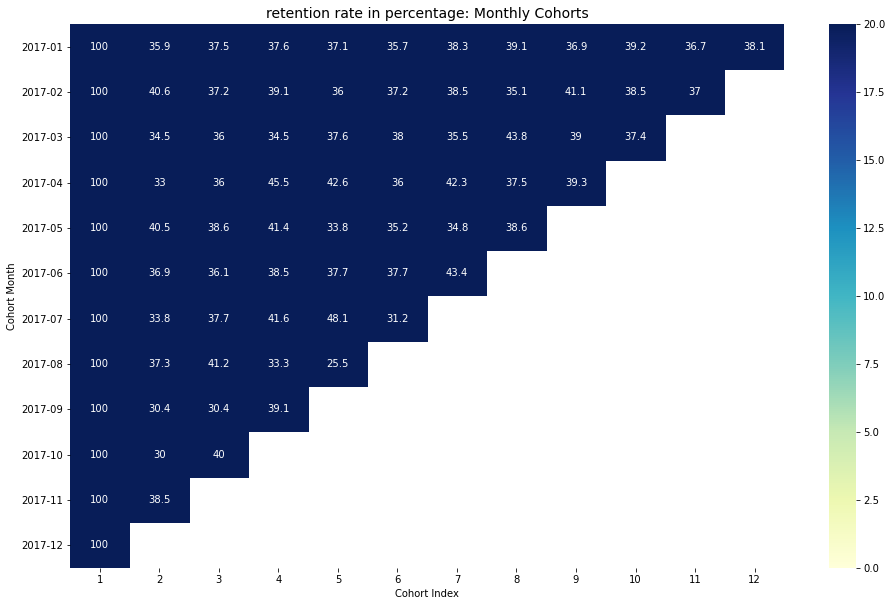

In [30]:
plt.figure(figsize=(16, 10))
plt.title('retention rate in percentage: Monthly Cohorts', fontsize = 14)
sns.heatmap(retention.round(3)*100, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

# Conclusion:

From this cohort analysis of retention rate, we can see the percentage of cohorts that signed in one particular month were 
active how many months later. here we cn see, in 2017-07 cohort month in 5th index, we see 48.1% which means that 48% of
cohorts that signed in july 2017 were active 5 months later.